In [1]:
# Copyright 2019-2020 Steven Mattis and Troy Butler

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde as GKDE
from luq import *
import ipywidgets as wd


In [2]:
plt.rcParams.update({'font.size': 22})
plt.rcParams.update({'axes.linewidth': 2})

np.random.seed(123456)

In [ ]:
The model is the 1D Burger's equation, a nonlinear PDE used to model fluid dynamics:
$$q_t + \frac{1}{2} (q^2)_x = 0.$$
The domain is the interval $[0, 10]$.
We have an initial condition of the form
\begin{equation*}
q(x,0) = \begin{cases} 
      f_l & 0 \leq x\leq 3.25 -a  \\
       \frac{1}{2} ((f_l + f_r) - (f_l - f_r) \frac{(x-3.25)}{a}) & 3.25 -a < x \leq 3.25 + a \\
      f_r & 3.25 + a < x \leq 10,
   \end{cases}
\end{equation*}
where $a \in [0, 3]$ is an uncertain parameter and $f_l$ and $f_r$ are positive constants with $f_l > f_r$. 
Take $f_l = 1.5$ and $f_r = 1$.
We assume non-reflecting boundary conditions, allowing waves to pass out of the boundaries without reflection.

Text(0.5, 1.0, 'Initial Condition')

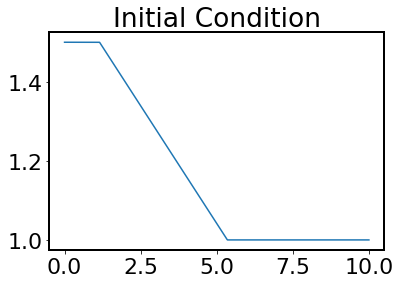

In [3]:
# Plot the initial condition given a, fl, and fr.
a = 2.1
fl = 1.5; fr = 1;
x = np.linspace(0, 10, 1000)
q0 = np.zeros(x.shape)
for i in range(x.shape[0]):
    if x[i] <= (3.25 - a):
        q0[i] = fl
    elif x[i] > (3.25 + a):
        q0[i] = fr
    else:
         q0[i] = 0.5 * ((fl + fr) - (fl - fr) * (x[i] - 3.25) / a)
fig = plt.figure()
plt.plot(x, q0)
plt.title('Initial Condition')

In [ ]:
This system often can develop discontinuous solutions (shock waves), which complicates calculating a numerical solution. 
We use Clawpack (https://www.clawpack.org/) to calculate weak solutions to the system using a Godunov-type finite volume method with an appropriate limiter and Riemann solver. 
We use a uniform mesh with 500 elements.

The system described above forms a shock at $t = \frac{2a}{f_l - f_r}$.
The shock speed is $\frac{1}{2}(f_l + f_r)$.

We calculte the time series solution at $x=7$, i.e. $q(7,t)$ at 500 evenly spaced time steps between 0 and 10.

Two ***true*** distributions of $a$ are defined by (non-uniform)
Beta distributions and used to generate a set of time series data.

An ***initial*** uniform distribution is assumed and updated by the true time series data.

In [5]:
# Load precomputed time-series data.
times = np.loadtxt('burgers_files_v4/unif_times.txt')
predicted_time_series = np.loadtxt('burgers_files_v4/unif_series.txt')
params = np.loadtxt('burgers_files_v4/unif_params.txt')
num_samples = predicted_time_series.shape[0]

# a=5, b=2
observed_time_series = np.loadtxt('burgers_files_v5/beta_series_2_2.txt')
params_obs = np.loadtxt('burgers_files_v5/beta_params_2_2.txt')
num_obs = observed_time_series.shape[0]

if len(params.shape) == 1:
    params = params.reshape((num_samples, 1))
    params_obs = params_obs.reshape((num_obs, 1))
    
# Add noise if desired
with_noise = True
noise_stdev = 0.025

if with_noise:
    predicted_time_series += noise_stdev * np.random.randn(num_samples, times.shape[0])
    observed_time_series += noise_stdev * np.random.randn(num_obs, times.shape[0])
param_range = np.array([[0.75, 3.0]])
param_labels = [r'$a$']

In [6]:
# Use LUQ to learn dynamics and QoIs
learn = LUQ(predicted_time_series, observed_time_series, times)

# time array indices over which to use
time_start_idx = 0 #0
time_end_idx = 499 #499

# Clean data with piecewise constant linear splines
learn.clean_data(time_start_idx=time_start_idx, time_end_idx=time_end_idx,
                 num_clean_obs=500, tol=0.5*noise_stdev, min_knots=3, max_knots=4)


0 4 0.01826368338734532
1 4 0.016350482094462448
1 4 knots being used with error of 0.016350482094462448
2 4 0.016474229918828322
2 4 knots being used with error of 0.016474229918828322
3 4 0.01674025246514533
4 4 0.01661011315032704
5 4 0.01685905460711225
6 4 0.01682303613147073
7 4 0.017131575902792733
8 4 0.01739756553272089
9 4 0.017395647521112747
10 4 0.016435257792598246
11 4 0.01642977094658945
12 4 0.017937784511524082
13 4 0.018250008726718357
14 4 0.017540218645100348
15 4 0.0164346763039581
15 4 knots being used with error of 0.0164346763039581
16 4 0.017187625526397972
17 4 0.01693568706889284
18 4 0.016677489332530913
18 4 knots being used with error of 0.016677489332530913
19 4 0.017073836212055646
20 4 0.016283114344657693
21 4 0.016615600332705045
22 4 0.016394198063041283
23 4 0.015965982112365048
24 4 0.016133019149710916
25 4 0.01641242167167336
26 4 0.01626050132357789
27 4 0.016666523547812277
28 4 0.01727551298496257
29 4 0.015682563877301797
30 4 0.016728573297

121 4 0.016614557713143942
122 4 0.016153481833655385
123 4 0.017035369396439504
124 4 0.0165092873670371
125 4 0.016953038821542386
126 4 0.017072409852231397
127 4 0.016111316697464767
128 4 0.017567680195412484
129 4 0.016170865186747926
130 4 0.016473972892351068
131 4 0.016092664108581876
132 4 0.01675561689893341
133 4 0.017191670228373
134 4 0.03884765325819347
135 4 0.016618007694309482
136 4 0.016732712076978153
137 4 0.01767356543719311
138 4 0.01675150708003853
139 4 0.016318706500699737
140 4 0.015477505813425836
141 4 0.016213818762970005
142 4 0.01782586394457408
143 4 0.01607602514916923
144 4 0.016503812002499296
145 4 0.017453724475015312
146 4 0.015526103666056832
147 4 0.016227345575115616
147 4 knots being used with error of 0.016227345575115616
148 4 0.016482113346472847
149 4 0.01742930519408466
150 4 0.01662587695879876
151 4 0.016797158106229906
151 4 knots being used with error of 0.016797158106229906
152 4 0.01693670188610065
153 4 0.0163036960719199
154 4 0.0

241 4 0.017052430801967597
242 4 0.01761051838989452
243 4 0.017695023890072336
244 4 0.01660137417310164
245 4 0.01712650936699485
246 4 0.017241364881832057
247 4 0.017265799038431145
248 4 0.016882281125788382
249 4 0.016185504126087116
250 4 0.01747131612372482
251 4 0.015608725328514598
252 4 0.01643477596243794
253 4 0.01645608670329514
254 4 0.015530994998021597
255 4 0.01774348511396149
256 4 0.01685673976970662
257 4 0.015783744746874353
258 4 0.01668772036736326
259 4 0.01822219721097051
260 4 0.016493481861498526
261 4 0.016903045209438635
262 4 0.017158455739176355
263 4 0.017026338082893794
264 4 0.016698753281402353
265 4 0.01749789768440807
266 4 0.01615377520323724
267 4 0.016788130431779576
268 4 0.016966070681742405
269 4 0.016002995627673777
270 4 0.017561899260566272
271 4 0.016027566173674075
272 4 0.017173874798644455
273 4 0.017404294177845534
274 4 0.016286662291527768
275 4 0.016467635118360927
276 4 0.017225661410815198
277 4 0.015686168609104347
278 4 0.01640

361 4 0.01684001869418005
362 4 0.016012921021810574
363 4 0.017083216414195447
364 4 0.017366865249963656
365 4 0.0171725615428836
366 4 0.01711518994024711
367 4 0.016942924220561914
368 4 0.016726447505182172
369 4 0.017389169235896756
370 4 0.016456170909780073
371 4 0.01777938806281239
372 4 0.016967817018023055
372 4 knots being used with error of 0.016967817018023055
373 4 0.017209705805513672
374 4 0.017019470202607127
375 4 0.014935202880696984
376 4 0.016434007194162964
377 4 0.01585076636420812
377 4 knots being used with error of 0.01585076636420812
378 4 0.016856267861538987
379 4 0.016187050614668783
380 4 0.016711120819898718
380 4 knots being used with error of 0.016711120819898718
381 4 0.016834141674576572
381 4 knots being used with error of 0.016834141674576572
382 4 0.016982194068225227
383 4 0.017830757823957023
384 4 0.01633293222378727
385 4 0.016494456672520252
386 4 0.016714606578675545
386 4 knots being used with error of 0.016714606578675545
387 4 0.01787348

481 4 0.01602184554370861
482 4 0.015869706310187148
483 4 0.016683565881637597
484 4 0.015918364695875716
485 4 0.017279633710692497
486 4 0.017478154084652586
487 4 0.01709944521967036
488 4 0.01671033133554486
489 4 0.01597323347859577
490 4 0.017432395023897217
491 4 0.017576741071313122
492 4 0.017308782174320383
493 4 0.01640541408313781
494 4 0.01571361430669163
495 4 0.016867129493072106
496 4 0.01629785375841977
497 4 0.016273196371419517
498 4 0.01686810208868236
499 4 0.01680756534623458
500 4 0.01604554847813648
501 4 0.017038471728187978
502 4 0.016133035141491975
503 4 0.016514119587886428
504 4 0.01698141932536608
505 4 0.015732161017780837
506 4 0.0164674724521735
507 4 0.017709388612121024
508 4 0.016876519010709412
509 4 0.017293364953831915
510 4 0.016760667505486212
511 4 0.01692722376712184
512 4 0.017441246663010078
513 4 0.015975445174350948
514 4 0.01825030195067937
515 4 0.016918645017183702
516 4 0.01730778479363732
517 4 0.016134618591056308
518 4 0.016395131

602 4 0.01676386191735655
603 4 0.016846568201481078
604 4 0.016924076249701478
605 4 0.01727904841008224
606 4 0.017358136902276767
607 4 0.017433657383471336
608 4 0.015605103042110996
609 4 0.016281427471484488
610 4 0.015452763878643326
611 4 0.017423478600796183
612 4 0.016004045413258765
613 4 0.01686866978875335
614 4 0.016140465790631074
615 4 0.01725789314126898
616 4 0.018144152099900175
617 4 0.016785947448676765
618 4 0.01648091407992614
619 4 0.01810921854105091
620 4 0.01600712975189081
621 4 0.016835636372764192
622 4 0.017162992014916674
623 4 0.015962350573988177
624 4 0.015852055204299664
625 4 0.016700129925151096
625 4 knots being used with error of 0.016700129925151096
626 4 0.016123002908086232
627 4 0.016163440574499654
628 4 0.01604629329590865
629 4 0.01686786834930597
630 4 0.016119437793428552
631 4 0.01689703255553418
632 4 0.01756159357746263
633 4 0.01724144605073527
634 4 0.015886043904643033
635 4 0.016565594471759426
636 4 0.01619159543415905
637 4 0.01

723 4 0.016487256682785133
724 4 0.015980072252830553
725 4 0.01710097369670525
726 4 0.016443644061374295
727 4 0.015931676192536166
728 4 0.016684083374002727
729 4 0.017460109309100667
730 4 0.016722498503530973
731 4 0.017810178453975607
732 4 0.016547764181927896
733 4 0.0156995970183579
734 4 0.0160758265269517
735 4 0.017111059393373113
736 4 0.016668595305855557
737 4 0.01620660332073334
738 4 0.01736732954579009
739 4 0.016874028006147904
740 4 0.016291623625381634
741 4 0.017440435360782217
742 4 0.015885508634249916
743 4 0.017702701655155594
744 4 0.017452918685109498
745 4 0.017393095639615594
746 4 0.016880004005486244
747 4 0.016693374681538458
748 4 0.017564828095270123
749 4 0.017620687041164308
750 4 0.0159972232199098
751 4 0.01662308207888089
752 4 0.016596444574438585
753 4 0.018510483727267556
754 4 0.015838397599010737
754 4 knots being used with error of 0.015838397599010737
755 4 0.016491346344510403
756 4 0.016962031820317046
757 4 0.01674870900728436
758 4 0.

842 4 0.017367131918808842
843 4 0.015553790776890432
844 4 0.01674745424094069
845 4 0.01541480901709116
846 4 0.016560745651863003
847 4 0.017034087276084756
848 4 0.01629665413780891
849 4 0.015364317295214444
850 4 0.01828016573972499
851 4 0.017465929591045343
852 4 0.017638128005949456
853 4 0.017273421911690737
854 4 0.015818147774357517
854 4 knots being used with error of 0.015818147774357517
855 4 0.016604680253145685
856 4 0.01675645272598724
857 4 0.017016115859430973
858 4 0.0165998533791977
859 4 0.01680848486257748
860 4 0.016378139109984802
861 4 0.01778399869101294
862 4 0.01705801639190124
863 4 0.01607722097336619
864 4 0.016467817715492394
865 4 0.01614195222955754
866 4 0.016691990750382905
867 4 0.01707009387406747
868 4 0.016267253795570338
869 4 0.01720568150095391
870 4 0.018315299279201957
871 4 0.01706175380106411
872 4 0.015827658082921255
873 4 0.016955262519411
874 4 0.01662085898468994
875 4 0.0169605283534736
876 4 0.017340532856427573
877 4 0.0172655325

963 4 0.017220990392719848
964 4 0.016973979861419016
965 4 0.017585135356720648
966 4 0.016256022714986388
967 4 0.016834242455649268
968 4 0.01705469244271951
969 4 0.01680425966090965
970 4 0.01790002231575391
971 4 0.017325925608246223
972 4 0.016412769333434895
973 4 0.015523510343626075
973 4 knots being used with error of 0.015523510343626075
974 4 0.01697627400550233
975 4 0.01661451820296425
975 4 knots being used with error of 0.01661451820296425
976 4 0.0170985467737896
977 4 0.016532766737915146
978 4 0.017498341150546073
979 4 0.017600903557879338
980 4 0.017497910568935817
981 4 0.016062777203444054
981 4 knots being used with error of 0.016062777203444054
982 4 0.01599079004337861
983 4 0.01653064705586469
984 4 0.01647569380480478
985 4 0.01638063544998082
986 4 0.016283883793703085
987 4 0.01604575061111608
988 4 0.01650687974575208
989 4 0.016241790779334367
989 4 knots being used with error of 0.016241790779334367
990 4 0.017116622554890146
991 4 0.016389614915718054

86 4 0.01709359694349448
87 4 0.017161820225176164
88 4 0.017023581685664813
89 4 0.01672657870198715
90 4 0.017926692021629307
91 4 0.017169768299401002
92 4 0.015932499829201426
93 4 0.016942373763273077
94 4 0.0158194584363942
95 4 0.016861107783853503
96 4 0.01731636112198736
97 4 0.017051926083780457
98 4 0.016984747656918837
99 4 0.01696860943644083
100 4 0.01734622176364507
101 4 0.015957852076510907
102 4 0.016484402402788
103 4 0.01676070912410026
104 4 0.015438676463056128
105 4 0.01718910501856368
106 4 0.016705138571354337
107 4 0.014957585942803144
108 4 0.018001879606505927
109 4 0.016339614407462018
110 4 0.016289401556618704
111 4 0.016530749177596615
112 4 0.01648552244083081
113 4 0.016304998912278806
114 4 0.01817931287704186
115 4 0.017511841885488204
116 4 0.01720807711965727
117 4 0.016854341133301146
118 4 0.016405380625379447
119 4 0.016240840813484807
120 4 0.01686185678214249
121 4 0.016411689325026735
122 4 0.016028872041442148
123 4 0.0165871901862993
124 4 

210 4 0.017339905291513892
211 4 0.016310623431236054
212 4 0.017548761288876218
213 4 0.017312820639019816
214 4 0.01721951865373156
215 4 0.01717641907301445
216 4 0.017054318053195353
217 4 0.017224036072194023
218 4 0.016634910231770723
219 4 0.016459528347663593
220 4 0.016219401692292777
221 4 0.01702070799006511
222 4 0.01652843476469542
223 4 0.016593023553270435
224 4 0.017520325120935966
225 4 0.01761876498714235
226 4 0.016550240642214727
227 4 0.01679994004598476
228 4 0.0164673375384176
229 4 0.016388350286107176
230 4 0.016838008529266948
231 4 0.017354890184571703
232 4 0.01767013782836898
233 4 0.01762735060482063
234 4 0.0168246618265268
235 4 0.01766532210248441
236 4 0.01671128312622873
237 4 0.016343883084170167
238 4 0.017057243031214885
239 4 0.017552245909304275
240 4 0.017246580056030563
241 4 0.016786294527075273
242 4 0.016998731894078543
243 4 0.016094492466126504
244 4 0.017188377698034704
245 4 0.01622393761758809
246 4 0.01650850361885658
247 4 0.017271880

333 4 0.01721547129969737
334 4 0.01717936675893938
335 4 0.01659004404810522
336 4 0.01753070760122011
337 4 0.017128538583825553
338 4 0.017572902245832786
339 4 0.01695183449010406
340 4 0.01563535539042859
341 4 0.015347056538083667
342 4 0.01695609224277235
343 4 0.015895557306121556
344 4 0.016267134859099287
345 4 0.01738492352674881
346 4 0.01709299492042647
347 4 0.01611585828407843
348 4 0.016929831976932753
349 4 0.016034351827005366
350 4 0.016754818287329592
351 4 0.016358895614303134
352 4 0.016319404045993777
353 4 0.016722092751389056
354 4 0.016346068767365714
355 4 0.01673045331801372
356 4 0.016753110596522038
357 4 0.016607126647595106
358 4 0.017269151125702816
359 4 0.016396959276789837
360 4 0.016229919312429297
361 4 0.01615747993630098
362 4 0.01730361171293301
363 4 0.017754323739853053
364 4 0.01619059827200233
365 4 0.015358980630470621
366 4 0.01726837338652147
367 4 0.01781598999743526
368 4 0.0165595992759274
369 4 0.017084787346002384
370 4 0.01764002489

453 4 0.016891550560739637
454 4 0.01666659934344897
455 4 0.01777188337092529
456 4 0.01654569352676231
457 4 0.016378654172826322
458 4 0.016720800995405332
459 4 0.01683989609627491
460 4 0.015799251487058123
461 4 0.016165589817513776
462 4 0.016861136257917297
463 4 0.01822397105011674
464 4 0.0172246588044634
465 4 0.017271345582958092
466 4 0.017216031343143732
467 4 0.017058291994380862
468 4 0.017366403098672347
469 4 0.0164950783930564
470 4 0.016984655537627635
471 4 0.01659727077889298
472 4 0.017252264182649513
473 4 0.01787179465755749
474 4 0.016530187275894306
475 4 0.016297649216837767
476 4 0.016868128569795828
477 4 0.016172206136881827
478 4 0.01737762451098736
479 4 0.016809566891215603
480 4 0.016568785253027504
481 4 0.01677005084220858
482 4 0.01670532127595139
483 4 0.017085444049899107
484 4 0.017548139969418633
485 4 0.016521466747172052
486 4 0.017343555145933106
487 4 0.017100244082042623
488 4 0.01732627237799322
489 4 0.017333612770113426
490 4 0.01609474

(array([[0.97648421, 0.97695291, 0.9774216 , ..., 1.49551659, 1.49547042,
         1.49542425],
        [0.9789521 , 0.97991297, 0.98087384, ..., 1.49474157, 1.4945985 ,
         1.49445542],
        [0.96827212, 0.96922745, 0.97018278, ..., 1.49903568, 1.49891177,
         1.49878785],
        ...,
        [0.97362767, 0.97448348, 0.97533929, ..., 1.50003088, 1.50007586,
         1.50012084],
        [0.99767095, 0.99769032, 0.99770969, ..., 1.50252188, 1.50251972,
         1.50251756],
        [0.97820241, 0.97884993, 0.97949746, ..., 1.4893891 , 1.48918041,
         1.48897172]]),
 array([[0.99443909, 0.99451457, 0.99459005, ..., 1.49218174, 1.49205594,
         1.49193014],
        [0.99656308, 0.99660839, 0.99665369, ..., 1.49754252, 1.49754799,
         1.49755345],
        [0.99585363, 0.99589368, 0.99593374, ..., 1.50697483, 1.50701272,
         1.50705062],
        ...,
        [0.9966331 , 0.9967173 , 0.99680151, ..., 1.5122296 , 1.51237005,
         1.51251051],
        [0.9

In [7]:
# Learn and classify dynamics.
learn.dynamics(cluster_method='kmeans', kwargs={'n_clusters': 2, 'n_init': 10})

0.011 misclassification rate for  {'kernel': 'linear'}
0.037 misclassification rate for  {'kernel': 'rbf'}
0.022 misclassification rate for  {'kernel': 'poly'}
0.4170000000000001 misclassification rate for  {'kernel': 'sigmoid'}
Best classifier is  {'kernel': 'linear'}
Misclassification rate is  0.011


Text(0.5, 1.0, 'Approximating Dynamics')

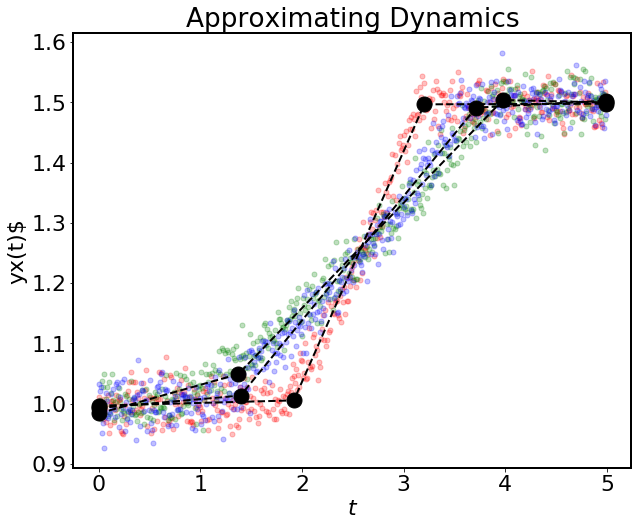

In [8]:
fig = plt.figure(figsize=(10,8))

# chosen_obs = [109, 8]

chosen_obs = [1, 3, 6]  #7]
colors = ['r', 'g', 'b']

for i, c in zip(chosen_obs,colors):
    plt.plot(learn.times[time_start_idx:time_end_idx+1], learn.observed_time_series[i,time_start_idx:time_end_idx+1],color=c, linestyle='none', marker='.', markersize=10, alpha=0.25)
    
for i in chosen_obs:
    num_i_knots = int(0.5*(2+len(learn.obs_knots[i])))
    knots = np.copy(learn.obs_knots[i][num_i_knots:])
    knots = np.insert(knots, 0, learn.clean_times[0])
    knots = np.append(knots, learn.clean_times[-1])
    plt.plot(knots, learn.obs_knots[i][:num_i_knots], 'k', linestyle='dashed', markersize=15, marker='o', linewidth=2)
    
plt.xlabel('$t$')
plt.ylabel('yx(t)$')
plt.title('Approximating Dynamics') 

Text(0.5, 1.0, 'Generating Clean Data')

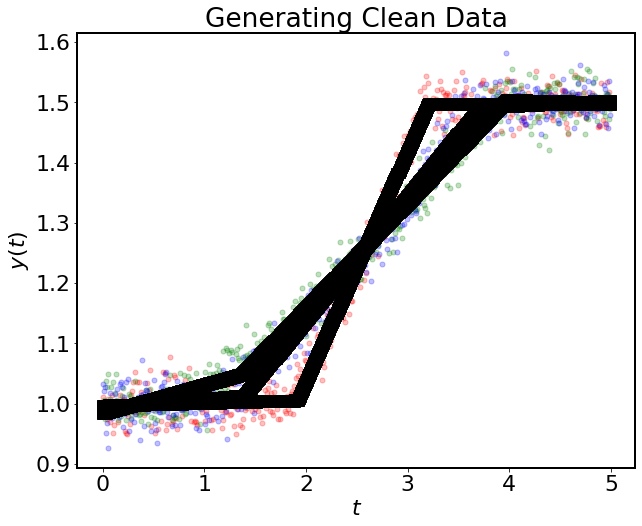

In [9]:
fig = plt.figure(figsize=(10,8))

for i, c in zip(chosen_obs,colors):
    plt.plot(learn.times[time_start_idx:time_end_idx+1], learn.observed_time_series[i,time_start_idx:time_end_idx+1],color=c, linestyle='none', marker='.', markersize=10, alpha=0.25)
    
for i in chosen_obs:
    plt.plot(learn.clean_times, learn.clean_obs[i,:],'k', linestyle='none', marker='s', 
            markersize=12)
    
plt.xlabel('$t$')
plt.ylabel('$y(t)$')
plt.title('Generating Clean Data') 

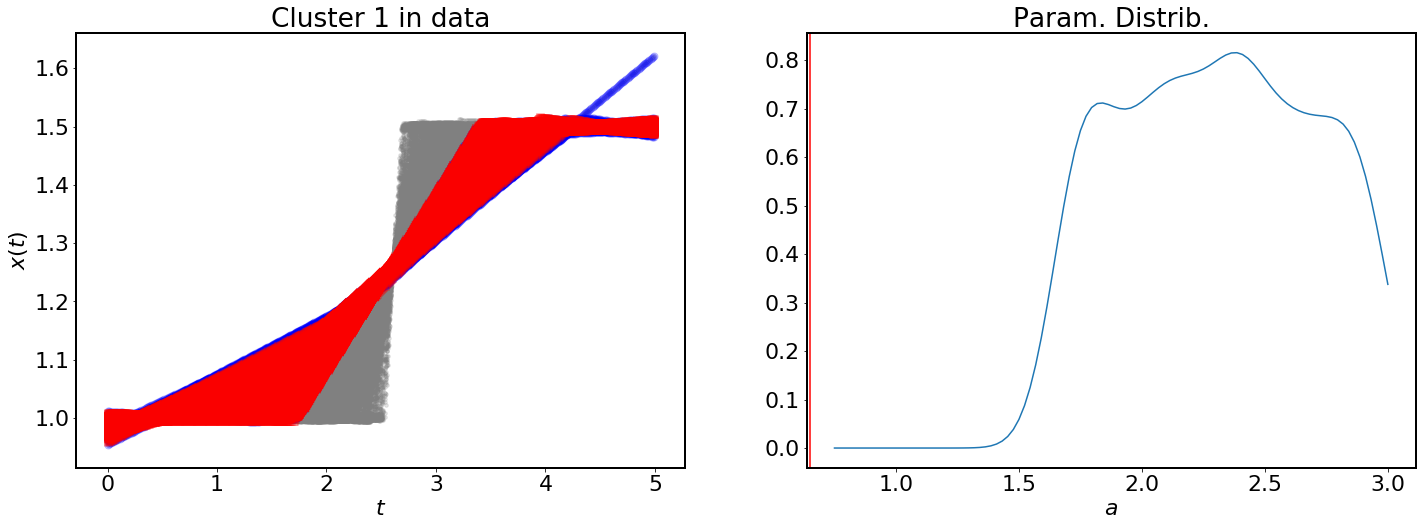

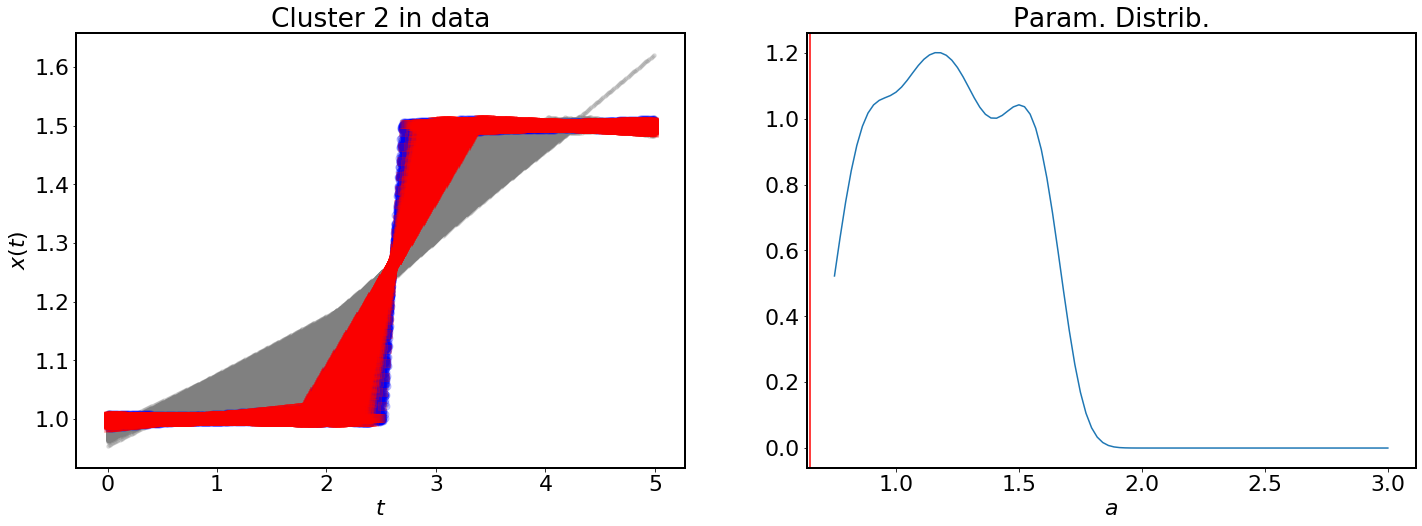

In [10]:
# # Plot clusters of predicted time series
num_clean_obs = learn.clean_times.shape[0]
for j in range(learn.num_clusters):
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(24,8), gridspec_kw={'width_ratios': [1, 1]}) 
    ax1.scatter(np.tile(learn.clean_times,num_samples).reshape(num_samples, num_clean_obs), 
                learn.clean_predictions, 50, c='gray', marker='.', alpha=0.2)
    idx = np.where(learn.predict_labels == j)[0]
    ax1.scatter(np.tile(learn.clean_times,len(idx)).reshape(len(idx),num_clean_obs), 
                learn.clean_predictions[idx,:], 50, c='b', marker='o', alpha=0.2)
    idx2 = np.where(learn.obs_labels == j)[0]    
    ax1.scatter(np.tile(learn.clean_times,len(idx2)).reshape(len(idx2),num_clean_obs), 
                learn.clean_obs[idx2, :], 50, c='r', marker='s', alpha=0.2)
    ax1.set(title='Cluster ' + str(j+1) + ' in data')
    ax1.set_xlabel('$t$')
    ax1.set_ylabel('$x(t)$')
    
    xs = np.linspace(param_range[0, 0], param_range[0, 1], 100)
    ax2.plot(xs, GKDE(params[idx].flat[:])(xs))
    ax2.axvline(x=.65, ymin=0.0, ymax=1.0, color='r')
    ax2.set(xlabel=param_labels[0], title='Param. Distrib.')
    
#     ax2.scatter(params[:,0], params[:,1], 30, c='gray', marker='.', alpha=0.2)
#     ax2.scatter(params[idx,0], params[idx,1], 50, c='blue', marker='o')
#     ax2.set(title='Cluster ' + str(j+1) + ' in parameters')
#     ax2.set_ylabel(param_labels[1])
#     ax2.set_xlabel(param_labels[0])
#     xs = np.linspace(param_range[0,0], param_range[0,1], 100)
#     ys1 = np.sqrt(0.5*(1.0 - np.sqrt(1.0 - 8.0*xs) -2.0*xs))
#     ys2 = np.sqrt(0.5*(1.0 + np.sqrt(1.0 - 8.0*xs) -2.0*xs))
#     ax2.plot(xs, ys1, 'r-', linewidth=3)
#     ax2.plot(xs, ys2, 'r-', linewidth=3)
    fig.tight_layout

In [11]:
# # Plot clusters of predicted time series
# for j in range(learn.num_clusters):
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,2.5), gridspec_kw={'width_ratios': [3, 1]}) #(figsize=(10,5))
#     ps = []
#     for i in range(num_samples):
#         if learn.predict_labels[i] == j:
#             ps.append(params[i,0])
#             ax1.plot(learn.clean_times, learn.clean_predictions[i, :])
#             #ax1.plot(times[time_start_idx : time_end_idx + 1], predicted_time_series[i, time_start_idx : time_end_idx + 1])
#     ax1.set(title='Cluster ' + str(j))
#     xs = np.linspace(param_range[0, 0], param_range[0,1], 100)
#     ax2.plot(xs, GKDE(ps)(xs))
#     ax2.set(xlabel=param_labels[0], title='Param. Distrib.')

In [12]:
# # Plot observed and predicted clusters
# for j in range(learn.num_clusters):
#     plt.figure()
#     cluster_num = j
#     for i in range(num_samples):
#         if learn.predict_labels[i] == cluster_num:
#             plt.plot(learn.clean_times, learn.clean_predictions[i,:],'b*')
#     for i in range(num_obs):
#         if learn.obs_labels[i] == cluster_num:
#             plt.plot(learn.clean_times, learn.clean_obs[i,:],'ro')

In [47]:
# Find best KPCA transformation for given number of QoI and transform time series data.
predict_map, obs_map = learn.learn_qois_and_transform(num_qoi=1,
                                                     proposals=({'kernel': 'linear'}, {'kernel': 'rbf'},
                             {'kernel': 'sigmoid'}, {'kernel': 'cosine'})) #variance_rate=0.95) #num_qoi=1)

1 principal components explain 64.1820% of variance for cluster 0 with {'kernel': 'linear'}
1 principal components explain 27.2702% of variance for cluster 0 with {'kernel': 'rbf'}
1 principal components explain 69.4598% of variance for cluster 0 with {'kernel': 'sigmoid'}
1 principal components explain 56.3918% of variance for cluster 0 with {'kernel': 'cosine'}
Best kPCA for cluster  0  is  {'kernel': 'sigmoid'}
1 principal components explain 69.4598% of variance.
1 principal components explain 29.2163% of variance for cluster 1 with {'kernel': 'linear'}
1 principal components explain 11.0089% of variance for cluster 1 with {'kernel': 'rbf'}
1 principal components explain 26.2849% of variance for cluster 1 with {'kernel': 'sigmoid'}
1 principal components explain 26.4559% of variance for cluster 1 with {'kernel': 'cosine'}
Best kPCA for cluster  1  is  {'kernel': 'linear'}
1 principal components explain 29.2163% of variance.


In [48]:
%reset -f out

def plot_gap(all_eig_vals, n, cluster):
    fig = plt.figure(figsize=(10,10))
    fig.clear()
    #Plotting until maximum number of knots
    eig_vals = all_eig_vals[cluster].lambdas_[0:10]
    plt.semilogy(np.arange(np.size(eig_vals))+1,eig_vals/np.sum(eig_vals)*100, Marker='.', MarkerSize=20, linestyle='')
    plt.semilogy(np.arange(np.size(eig_vals))+1,eig_vals[n]/np.sum(eig_vals)*100*np.ones(np.size(eig_vals)), 'k--')
    plt.semilogy(np.arange(np.size(eig_vals))+1,eig_vals[n+1]/np.sum(eig_vals)*100*np.ones(np.size(eig_vals)), 'r--')
    plt.text(n+1, eig_vals[n]/np.sum(eig_vals)*150, 
             r'%2.3f' %(np.sum(eig_vals[0:n+1])/np.sum(eig_vals)*100) + '% of variation explained by first ' + '%1d' %(n+1) + ' PCs.', 
                                                               {'color': 'k', 'fontsize': 20})
    plt.text(n+2, eig_vals[n+1]/np.sum(eig_vals)*150, 
             r'Order of magnitude of gap is %4.2f.' %(np.log10(eig_vals[n])-np.log10(eig_vals[n+1])), 
                                                               {'color': 'r', 'fontsize': 20})
    s = 'Determining QoI for cluster #%1d' %(cluster+1)
    plt.title(s)
    plt.xlabel('Principal Component #')
    plt.ylabel('% of Variation')
    plt.xlim([0.1, np.size(eig_vals)+1])
    plt.ylim([0,500])


wd.interact(plot_gap, all_eig_vals=wd.fixed(learn.kpcas),
            n = wd.IntSlider(value=0, min=0, max=5),
            cluster = wd.IntSlider(value=0, min=0, max=learn.num_clusters-1))

Flushing output cache (1 entries)


interactive(children=(IntSlider(value=0, description='n', max=5), IntSlider(value=0, description='cluster', ma…

<function __main__.plot_gap(all_eig_vals, n, cluster)>

In [49]:
# Generate kernel density estimates on new QoI
learn.generate_kdes()
# Calculate rejection rates for each cluster and print averages.
r_vals=learn.compute_r()

Diagnostic for clusters [sample average of ratios in each cluster]: [1.0107271017807737, 0.987482806612031]


In [50]:
# Compute marginal probablities for each parameter and initial condition.
param_marginals = []
true_param_marginals = []
lam_ptr = []
cluster_weights = []
for i in range(learn.num_clusters):
    lam_ptr.append(np.where(learn.predict_labels == i)[0])
    cluster_weights.append(len(np.where(learn.obs_labels == i)[0]) / num_obs)

for i in range(params.shape[1]):
    true_param_marginals.append(GKDE(params_obs[:,i]))
    param_marginals.append([])
    for j in range(learn.num_clusters):
        param_marginals[i].append(GKDE(params[lam_ptr[j], i], weights=learn.r[j]))
        

In [51]:
# uniform distribution
def unif_dist(x, p_range):
    y = np.zeros(x.shape)
    val = 1.0/(p_range[1] - p_range[0])
    for i, xi in enumerate(x):
        if xi < p_range[0] or xi >  p_range[1]:
            y[i] = 0
        else:
            y[i] = val
    return y

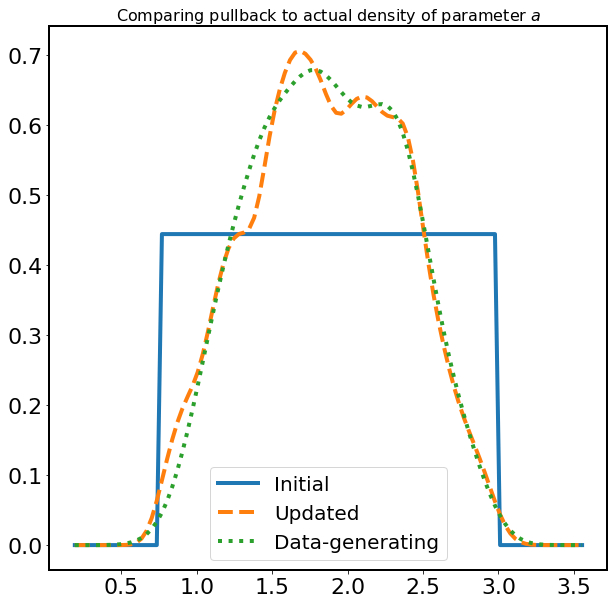

In [52]:
# Plot predicted marginal densities for parameters

for i in range(params.shape[1]):
    fig = plt.figure(figsize=(10,10))
    fig.clear()
    x_min = min(min(params[:, i]), min(params_obs[:, i]))
    x_max = max(max(params[:, i]), max(params_obs[:, i]))
    delt = 0.25*(x_max - x_min)
    x = np.linspace(x_min-delt, x_max+delt, 100)
    plt.plot(x, unif_dist(x, param_range[i, :]),
         label = 'Initial', linewidth=4)
    mar = np.zeros(x.shape)
    for j in range(learn.num_clusters):
        mar += param_marginals[i][j](x) * cluster_weights[j]
    plt.plot(x, mar, label = 'Updated', linewidth=4, linestyle='dashed')
    plt.plot(x, true_param_marginals[i](x), label = 'Data-generating', 
             linewidth=4, linestyle='dotted')
    plt.title('Comparing pullback to actual density of parameter ' + param_labels[i], fontsize=16)
    plt.legend(fontsize=20)

### Compute TV metric between densities

In [53]:
import scipy.integrate.quadrature as quad

In [54]:
def param_init_error(x):
    return np.abs(unif_dist(x,param_range[param_num, :])-true_param_marginals[param_num](x))

for i in range(params.shape[1]):
    param_num=i
    TV_metric = quad(param_init_error,param_range[i,0],param_range[i,1],maxiter=1000)
    print(TV_metric)

(0.4305616473897793, 9.868086736641857e-09)


In [55]:
def param_update_KDE_error(x):
    mar = np.zeros(x.shape)
    for j in range(learn.num_clusters):
        mar += param_marginals[param_num][j](x) * cluster_weights[j]
    return np.abs(mar-true_param_marginals[param_num](x))

for i in range(params.shape[1]):
    param_num=i
    TV_metric = quad(param_update_KDE_error,param_range[i,0],param_range[i,1],maxiter=1000)
    print(TV_metric)

(0.054400578753700524, 1.1616165321304273e-08)


In [56]:
from scipy.stats import beta 

In [57]:
true_a = 2.0
true_b = 2.0
def KDE_error(x):
    true_beta = beta(a=true_a, b=true_b,loc=param_range[i,0],scale=param_range[i,1]-param_range[i,0])
    return np.abs(true_beta.pdf(x)-true_param_marginals[param_num](x))

for i in range(params.shape[1]):
    param_num=i
    TV_metric = quad(KDE_error,param_range[i,0],param_range[i,1],maxiter=1000)
    print(TV_metric)

(0.05851673412391385, 8.207582363750632e-09)


In [24]:
# Load precomputed time-series data at x=9.5.
# a=2, b=5
predicted_time_series2 = np.loadtxt('burgers_files_v4/unif_series2.txt')
observed_time_series2 = np.loadtxt('burgers_files_v5/beta_series2_2_2.txt')
params_obs2 = np.loadtxt('burgers_files_v5/beta_params_2_2.txt')
num_obs2 = observed_time_series.shape[0]
params_obs2 = params_obs2.reshape((num_obs2, 1))

# Add noise if desired
with_noise = True
noise_stdev = 0.025

if with_noise:
    predicted_time_series2 += noise_stdev * np.random.randn(num_samples, times.shape[0])
    observed_time_series2 += noise_stdev * np.random.randn(num_obs2, times.shape[0])


In [25]:
# Use LUQ to learn dynamics and QoIs
learn2 = LUQ(predicted_time_series2, observed_time_series2, times)

# time array indices over which to use
time_start_idx = 250 #0
time_end_idx = 749 #499

# Clean data with piecewise constant linear splines
learn2.clean_data_tol(time_start_idx=time_start_idx, time_end_idx=time_end_idx,
                 num_clean_obs=500, tol=0.5*noise_stdev, min_knots=3, max_knots=4)


0 3 0.0408608610550218
0 4 0.017104008274585487
1 3 0.02470108194091043
1 4 0.016319997485184763
2 3 0.027642691926951006
2 4 0.017094416184925514
3 3 0.07408142058950778
3 4 0.016244308826371803
4 3 0.04161112395040134
4 4 0.016654504580377864
5 3 0.039987986160769665
5 4 0.01630301109563742
6 3 0.03171002745772388
6 4 0.01690885617386991
7 3 0.05733462214083307
7 4 0.014932041363836782
8 3 0.07388375798740979
8 4 0.015423840183128215
9 3 0.04500704679125056
9 4 0.017137721490454443
10 3 0.07357494455947373
10 4 0.01529138447623352
11 3 0.036344805136604263
11 4 0.016336920503412577
12 3 0.03980303902323474
12 4 0.01653879224382938
13 3 0.07575836885161792
13 4 0.016907873992580123
14 3 0.03668044926313882
14 4 0.016804200654165255
15 3 0.02776484597027352
15 4 0.016051485004521776
16 3 0.061825895494500814
16 4 0.015005404063738513
17 3 0.035021483423522896
17 4 0.017626643147292086
18 3 0.027951108919779314
18 4 0.018175988422786303
19 3 0.04430116791245296
19 4 0.016211183295171586

89 4 0.01698633640262181
90 3 0.04005921109888133
90 4 0.017008556605835008
91 3 0.030213540150432035
91 4 0.01635288915894323
92 3 0.0655102382084744
92 4 0.015024883550628022
93 3 0.027467007551386497
93 4 0.016505434402304946
94 3 0.06508278746733873
94 4 0.01602901170011412
95 3 0.03568769492099871
95 4 0.01630319787140864
96 3 0.05761201396738576
96 4 0.016359399246263562
97 3 0.05543594318038936
97 4 0.0172788732906156
98 3 0.0496215233510629
98 4 0.016645395864521358
99 3 0.05037276408188168
99 4 0.016324248005401266
100 3 0.06390728609245949
100 4 0.01580347880226209
101 3 0.04340516491573888
101 4 0.01743130905117251
102 3 0.07302280802391369
102 4 0.016894541449753595
103 3 0.02644244199786678
103 4 0.01683469865879889
104 3 0.0729687504770359
104 4 0.015112608532469868
105 3 0.0562682284803733
105 4 0.01622662163915318
106 3 0.06631807332507952
106 4 0.01604260876321522
107 3 0.04481923907026748
107 4 0.015476809187163862
108 3 0.05838183511130867
108 4 0.015605346050713096


176 4 0.016361867142583194
177 3 0.07342964827664095
177 4 0.0164039530866674
178 3 0.0590329596374066
178 4 0.016508700720861105
179 3 0.04963342616396731
179 4 0.015689411660156465
180 3 0.073048149422816
180 4 0.015084619002666687
181 3 0.07377791390836311
181 4 0.01543238105226844
182 3 0.027202904994293346
182 4 0.01741151681902314
183 3 0.039201761512211594
183 4 0.016510088562101916
184 3 0.07354208222577222
184 4 0.016812641493252446
185 3 0.03774124026122759
185 4 0.016201838273921063
186 3 0.0618486921434193
186 4 0.016571550545798328
187 3 0.032780702803382654
187 4 0.018328444404438347
188 3 0.0421951376720343
188 4 0.016828052121113206
189 3 0.060240926710164254
189 4 0.016544457099485318
190 3 0.06722302168159437
190 4 0.015462784640258184
191 3 0.039826298239076185
191 4 0.017242722420824804
192 3 0.03986330386568358
192 4 0.01672560436817842
193 3 0.045175340255995046
193 4 0.01699925468573507
194 3 0.04175399162506083
194 4 0.017443036334660385
195 3 0.0435296496860901

264 4 0.015628472765194062
265 3 0.06536270385048794
265 4 0.015728415935128776
266 3 0.0304978712796916
266 4 0.01646923591617855
267 3 0.037259567465127416
267 4 0.015781983553089685
268 3 0.04742483716439863
268 4 0.0180407679305526
269 3 0.054149018275368596
269 4 0.01606411244190539
270 3 0.05997351198160139
270 4 0.015316897835894372
271 3 0.02936284278434194
271 4 0.01634264838232404
272 3 0.03978547563255405
272 4 0.016694764455266464
273 3 0.0515712634892779
273 4 0.016633982257572566
274 3 0.07295730423093502
274 4 0.015910200882878273
275 3 0.033267136580391925
275 4 0.017290813312983103
276 3 0.05663377930474831
276 4 0.016303963638564685
277 3 0.07360348854066598
277 4 0.016324884819103234
278 3 0.07369274672518594
278 4 0.015924835918422305
279 3 0.038435999537696046
279 4 0.015608801712118281
280 3 0.07309511469511434
280 4 0.015791648228238867
281 3 0.03185293653257466
281 4 0.01713532919606258
282 3 0.04535159424584379
282 4 0.016580006900071196
283 3 0.055665496112354

353 4 0.017074894392478456
354 3 0.07036159253369376
354 4 0.015455301061524703
355 3 0.029609301495998303
355 4 0.017448255008986533
356 3 0.03083552957555003
356 4 0.016252842822127397
357 3 0.027037178509191195
357 4 0.017151268214265023
358 3 0.026683285268563672
358 4 0.016598155744853453
359 3 0.0425467244620044
359 4 0.016907526656196648
360 3 0.04613235234746109
360 4 0.015675316133349777
361 3 0.07435030723304496
361 4 0.015787996567722368
362 3 0.02720057921297356
362 4 0.016449127204751335
363 3 0.07242585727575561
363 4 0.01593385088858471
364 3 0.05885916917978512
364 4 0.01664129142227946
365 3 0.055685285901813986
365 4 0.01649091407046892
366 3 0.0486665741272572
366 4 0.016741877231585385
367 3 0.0570873060739412
367 4 0.0175681996591823
368 3 0.07467632087198581
368 4 0.01725644062565127
369 3 0.032433071863194225
369 4 0.01685410778300561
370 3 0.05223645679068614
370 4 0.016524192053145186
371 3 0.05899766293912359
371 4 0.016690667968158428
372 3 0.0286780279756974

442 3 0.033615180310896525
442 4 0.017433870403617692
443 3 0.061511132449896325
443 4 0.01623410334636238
444 3 0.07366744876682185
444 4 0.015801419385477602
445 3 0.0558236024575622
445 4 0.017239131380511735
446 3 0.054253502261515034
446 4 0.016473112708292
447 3 0.05576666569676577
447 4 0.016171583896073594
448 3 0.03806109131507298
448 4 0.01663658639511695
449 3 0.07351395223159962
449 4 0.015280333572057563
450 3 0.07303227956626515
450 4 0.01588275681052884
451 3 0.07405857038977401
451 4 0.015479279989722336
452 3 0.026155873802720272
452 4 0.017141786405803393
453 3 0.0342576392006715
453 4 0.015838659486895716
454 3 0.07435881749270368
454 4 0.01631537159750697
455 3 0.025400103410643304
455 4 0.017135920613092968
456 3 0.025034418139699983
456 4 0.016618942932622387
457 3 0.0609272708250421
457 4 0.016022416295987496
458 3 0.05581673680152676
458 4 0.015280119296472898
459 3 0.07455710289614213
459 4 0.01500543429138153
460 3 0.0737220646726121
460 4 0.015080912042798218

531 4 0.01625961263258022
532 3 0.04743402486618625
532 4 0.016746576937463856
533 3 0.04959470884149012
533 4 0.016098512657532385
534 3 0.0744158773665548
534 4 0.015133457927011927
535 3 0.043172443865037415
535 4 0.01582458466978914
536 3 0.06827839668718466
536 4 0.01603444483566741
537 3 0.07386762840481197
537 4 0.016119494804608264
538 3 0.029731784581921408
538 4 0.017708407196097186
539 3 0.07491705274197723
539 4 0.016020406847544043
540 3 0.051033933160381816
540 4 0.01644993036737147
541 3 0.064435360444264
541 4 0.016407216938513904
542 3 0.07434538110211547
542 4 0.01603161019580123
543 3 0.07463039567305896
543 4 0.014585571418955367
544 3 0.03192952392938504
544 4 0.017675495819090253
545 3 0.06414318605356847
545 4 0.015460927599602456
546 3 0.029152455608746106
546 4 0.01592057692882357
547 3 0.025468867178841198
547 4 0.017119596655275845
548 3 0.04718491388772769
548 4 0.015160901689963691
549 3 0.03829946096257058
549 4 0.017179686863583236
550 3 0.073568881961692

618 4 0.015710990819372453
619 3 0.0634060333772615
619 4 0.016859753449062546
620 3 0.07186720820456817
620 4 0.016386829113828244
621 3 0.04809905241625522
621 4 0.016100101040329284
622 3 0.04712405855933726
622 4 0.01663327631514061
623 3 0.06574116163854656
623 4 0.014970958865723357
624 3 0.07308282961042249
624 4 0.015894694357233757
625 3 0.02723977071875393
625 4 0.01636684958777965
626 3 0.03855996729172245
626 4 0.016683731729241768
627 3 0.07066484037659973
627 4 0.016877312361385576
628 3 0.056484111850842345
628 4 0.015768547895182373
629 3 0.05230423315138891
629 4 0.01730735093796311
630 3 0.07394647732435924
630 4 0.015711772993201017
631 3 0.06837805511086295
631 4 0.01666691990457827
632 3 0.05433069861491784
632 4 0.016388362149421163
633 3 0.02935572095427663
633 4 0.016400542511109367
634 3 0.07418759811355491
634 4 0.015116722082557243
635 3 0.0749764774052559
635 4 0.01625927236523305
636 3 0.0742711244800227
636 4 0.015398025496354297
637 3 0.026538883157382953

706 4 0.0170488458059613
707 3 0.032753091907259405
707 4 0.0152159006593107
708 3 0.07300746313215507
708 4 0.015990383295173157
709 3 0.06777166208956074
709 4 0.016284324476542374
710 3 0.06423174868200984
710 4 0.015533596003907555
711 3 0.04855042668263033
711 4 0.016550142264926838
712 3 0.06461339292961232
712 4 0.01481871723758944
713 3 0.036003097564966106
713 4 0.016784870139845722
714 3 0.06074234199906919
714 4 0.015866815434120756
715 3 0.07376333714020722
715 4 0.01726650454229882
716 3 0.05938690486440947
716 4 0.015838495855538974
717 3 0.025197206594109695
717 4 0.017546709881653005
718 3 0.050722678794603876
718 4 0.015923213309404244
719 3 0.024318227107241543
719 4 0.0172586150994752
720 3 0.07335220716709036
720 4 0.016384715267535804
721 3 0.0549936102619753
721 4 0.016072137826159853
722 3 0.028392932442459624
722 4 0.017983082611602755
723 3 0.02763954032370293
723 4 0.016623861900047655
724 3 0.0624861613753018
724 4 0.015882074105549523
725 3 0.035419310273288

794 3 0.07422153453488096
794 4 0.016736495548941823
795 3 0.07397670636115701
795 4 0.015833579881960276
796 3 0.059072053702332594
796 4 0.016589287684973385
797 3 0.07256733983691331
797 4 0.015937933515869564
798 3 0.039317196702520714
798 4 0.016311083049575587
799 3 0.07480288077042907
799 4 0.015868578499183935
800 3 0.03281374781022853
800 4 0.017096321630742657
801 3 0.07539991578566091
801 4 0.016422719072869862
802 3 0.07344994364082898
802 4 0.016309127357074116
803 3 0.02655975073261375
803 4 0.017291360516162917
804 3 0.07097469995740299
804 4 0.017412341428281367
805 3 0.030504332808329596
805 4 0.016452657550675782
806 3 0.04867953805849703
806 4 0.01674111315311433
807 3 0.05320795377292059
807 4 0.016839165310940145
808 3 0.07345263944269101
808 4 0.015316464106663282
809 3 0.0724389040492628
809 4 0.015836422953597547
810 3 0.060854223272485394
810 4 0.016320235224154885
811 3 0.05732382480397213
811 4 0.01681525064079231
812 3 0.0735884760163756
812 4 0.015698886654

886 3 0.035461964654432784
886 4 0.0167226474869213
887 3 0.030455552347186967
887 4 0.0168380075641185
888 3 0.07162294698413726
888 4 0.015617439537436375
889 3 0.03234377041162247
889 4 0.01656300201627033
890 3 0.04537305154775694
890 4 0.016748998901978174
891 3 0.07280351493320782
891 4 0.01536709662605924
892 3 0.06590405389098018
892 4 0.015133140841046605
893 3 0.07477524521282439
893 4 0.016380993944269277
894 3 0.07423651972972058
894 4 0.01597420263624092
895 3 0.0724237721517323
895 4 0.016627716378758917
896 3 0.058341743348902284
896 4 0.016057189354689236
897 3 0.02663563690171217
897 4 0.016730662316518777
898 3 0.06524243588235983
898 4 0.015698987445381885
899 3 0.04372538516223638
899 4 0.016100089391169612
900 3 0.039751737995113196
900 4 0.01704179675295572
901 3 0.0301079941271606
901 4 0.01762247800834811
902 3 0.07370755180333372
902 4 0.016186156264193927
903 3 0.028028141149396363
903 4 0.017242636000689412
904 3 0.0693687812165635
904 4 0.01632310276337066
9

978 3 0.04707672153333352
978 4 0.016640939813039945
979 3 0.04363170055903957
979 4 0.016974546123661272
980 3 0.060709572519566934
980 4 0.01636609658147576
981 3 0.028400472706127996
981 4 0.018560706305615654
982 3 0.06672856539843701
982 4 0.016769224007402793
983 3 0.06680965954887262
983 4 0.016232004750224117
984 3 0.0599843336650506
984 4 0.015823579411398725
985 3 0.07479827757156192
985 4 0.015763711363865812
986 3 0.043325516253718666
986 4 0.01654305924434912
987 3 0.058254847958323
987 4 0.016255312800476207
988 3 0.058517310746466294
988 4 0.0163545789654865
989 3 0.026224191712054087
989 4 0.016614581237349258
990 3 0.04636522426094616
990 4 0.01731841400031267
991 3 0.0747225597930493
991 4 0.016147062061208695
992 3 0.05511002233098371
992 4 0.016670669180111654
993 3 0.0597241607681436
993 4 0.016455930333518866
994 3 0.03516399600161077
994 4 0.01707912210689904
995 3 0.07016621581417443
995 4 0.015756282191656496
996 3 0.07398325444214582
996 4 0.01589787709609579


72 4 0.016740935444559558
73 3 0.05574265586664199
73 4 0.016031595665210147
74 3 0.0429450934938381
74 4 0.01664503761223745
75 3 0.04148269467971479
75 4 0.016864476445261213
76 3 0.07424994517791163
76 4 0.01624091063204337
77 3 0.0682749710334359
77 4 0.01604904552672843
78 3 0.06605477664582096
78 4 0.01590055528630192
79 3 0.033785224603024494
79 4 0.016620612126142485
80 3 0.0281617914532428
80 4 0.01630596565987305
81 3 0.07184954763888723
81 4 0.015902793351507464
82 3 0.07328591331286871
82 4 0.015421813781681785
83 3 0.0461615086678196
83 4 0.015837102727614964
84 3 0.05713410147295927
84 4 0.016094740702649248
85 3 0.07352752355003933
85 4 0.015670247957361
86 3 0.054462427393494064
86 4 0.016423932901065228
87 3 0.0737301551457863
87 4 0.016656874096385124
88 3 0.07210926655586163
88 4 0.016137529886572757
89 3 0.054408379140664626
89 4 0.016887725235313816
90 3 0.03997511449896859
90 4 0.015727076190385526
91 3 0.05516192951785352
91 4 0.01587918024400182
92 3 0.046541647

160 3 0.04170840095142693
160 4 0.0155175369467402
161 3 0.07416063528017862
161 4 0.015393304089840618
162 3 0.06591069839379372
162 4 0.016151835180639958
163 3 0.031155381976543703
163 4 0.016081382867917236
164 3 0.061660738030296015
164 4 0.01579272540920072
165 3 0.037232850290416133
165 4 0.016387925308049122
166 3 0.040615160152663615
166 4 0.016977235012219313
167 3 0.046300321577102246
167 4 0.01686169481091444
168 3 0.06516036322014546
168 4 0.01565461970269074
169 3 0.04030255616921272
169 4 0.016545434938142152
170 3 0.04065216945459171
170 4 0.016149055729995324
171 3 0.0658332406436723
171 4 0.016624974052222012
172 3 0.059636903683974604
172 4 0.01602350704151794
173 3 0.04553931863287117
173 4 0.016918598719862846
174 3 0.03626406258710839
174 4 0.01717610669707948
175 3 0.04335370909030737
175 4 0.016427387850125832
176 3 0.056732910349923164
176 4 0.01599549066181423
177 3 0.03412038545933597
177 4 0.017102099490311846
178 3 0.07174450233456102
178 4 0.01619503410412

253 3 0.058543763033969895
253 4 0.015990951014034485
254 3 0.07441075920104079
254 4 0.016035666552147512
255 3 0.029155780381236777
255 4 0.018149273475555783
256 3 0.047687788354114885
256 4 0.015875886503592306
257 3 0.031770471486765615
257 4 0.01711594991513452
258 3 0.0464799895805291
258 4 0.01688235648802721
259 3 0.057488065844299
259 4 0.016577583943470593
260 3 0.07549942466248541
260 4 0.01642130398367504
261 3 0.0509992222372677
261 4 0.015646886672181698
262 3 0.049584386238054876
262 4 0.016566189868741695
263 3 0.051292528993355804
263 4 0.0167538468597618
264 3 0.05310968937495869
264 4 0.01671198384133282
265 3 0.056505963394370744
265 4 0.015484999428931294
266 3 0.05437003962879159
266 4 0.015915405144364944
267 3 0.034175564702367205
267 4 0.016952066884563546
268 3 0.04936473388591018
268 4 0.018145357174817106
269 3 0.06642172707592767
269 4 0.015972159966719007
270 3 0.044531896503177425
270 4 0.01702029116716321
271 3 0.04888135029270337
271 4 0.01530646068502

343 3 0.066560050458699
343 4 0.01615910185647597
344 3 0.04135584123003452
344 4 0.016410299613429942
345 3 0.04010215047448279
345 4 0.016445485858882843
346 3 0.06015203025408915
346 4 0.016314428496530402
347 3 0.05310279834278674
347 4 0.01568687160939779
348 3 0.06219851094510136
348 4 0.015893216354279625
349 3 0.06802962294288672
349 4 0.016344733765110007
350 3 0.06375143333966353
350 4 0.015761300572688167
351 3 0.05519553331540049
351 4 0.016194911470352513
352 3 0.0661124892872696
352 4 0.016598062711862854
353 3 0.04416753995771758
353 4 0.017092034831251584
354 3 0.0305334802565348
354 4 0.018060119635175242
355 3 0.033756617275341336
355 4 0.017746025342993674
356 3 0.03748402697426573
356 4 0.016107198303167713
357 3 0.06063695392934641
357 4 0.015935303104294977
358 3 0.04691751118543955
358 4 0.0171977481286043
359 3 0.054352973288517806
359 4 0.016141797348329077
360 3 0.05208395651646853
360 4 0.016313614919438203
361 3 0.048142983338542875
361 4 0.01718635452532285

431 3 0.042397111044388466
431 4 0.01648978449600553
432 3 0.0704449496029397
432 4 0.015604397558488614
433 3 0.07469749076447559
433 4 0.016448838648085943
434 3 0.04965687284296083
434 4 0.01576345268468824
435 3 0.06825310875228474
435 4 0.01566936662997212
436 3 0.03925093125345914
436 4 0.015173400160453095
437 3 0.07342568859339327
437 4 0.015333898531263341
438 3 0.06127282159296254
438 4 0.016110274456568974
439 3 0.052144053741548714
439 4 0.016795304664677317
440 3 0.03579174258841901
440 4 0.016663515299779812
441 3 0.04325412255105983
441 4 0.01699172260131784
442 3 0.06091971717054155
442 4 0.01594470394718272
443 3 0.05748388492208362
443 4 0.016402047605235448
444 3 0.07537774418575932
444 4 0.016357262524664386
445 3 0.05386873680188072
445 4 0.017514593292565526
446 3 0.037977371536845245
446 4 0.015916931026772444
447 3 0.06740576258208737
447 4 0.015168796555509964
448 3 0.05141489557350958
448 4 0.015724713623412354
449 3 0.05067671026824931
449 4 0.016793316516983

(array([[0.99479332, 0.99489767, 0.99500201, ..., 1.5000402 , 1.49998419,
         1.49992819],
        [0.97511211, 0.97571733, 0.97632255, ..., 1.49672018, 1.49665266,
         1.49658514],
        [0.98622421, 0.98656817, 0.98691213, ..., 1.50703006, 1.50716966,
         1.50730926],
        ...,
        [0.98639379, 0.98677128, 0.98714878, ..., 1.49558235, 1.49552381,
         1.49546526],
        [0.99981301, 0.99980528, 0.99979756, ..., 1.49607634, 1.49604352,
         1.4960107 ],
        [0.98715951, 0.98732524, 0.98749097, ..., 1.50169758, 1.50170871,
         1.50171983]]),
 array([[0.99542232, 0.99550278, 0.99558324, ..., 1.49678827, 1.49675435,
         1.49672044],
        [0.99752096, 0.99753685, 0.99755274, ..., 1.49736189, 1.49734046,
         1.49731902],
        [1.00488372, 1.00486935, 1.00485497, ..., 1.50343522, 1.50344654,
         1.50345785],
        ...,
        [0.9954898 , 0.99551382, 0.99553783, ..., 1.50053284, 1.50052907,
         1.5005253 ],
        [0.9

In [26]:
# Learn and classify dynamics.
learn2.dynamics(cluster_method='kmeans', kwargs={'n_clusters': 2, 'n_init': 10})

0.001 misclassification rate for  {'kernel': 'linear'}
0.019 misclassification rate for  {'kernel': 'rbf'}
0.006 misclassification rate for  {'kernel': 'poly'}
0.48 misclassification rate for  {'kernel': 'sigmoid'}
Best classifier is  {'kernel': 'linear'}
Misclassification rate is  0.001


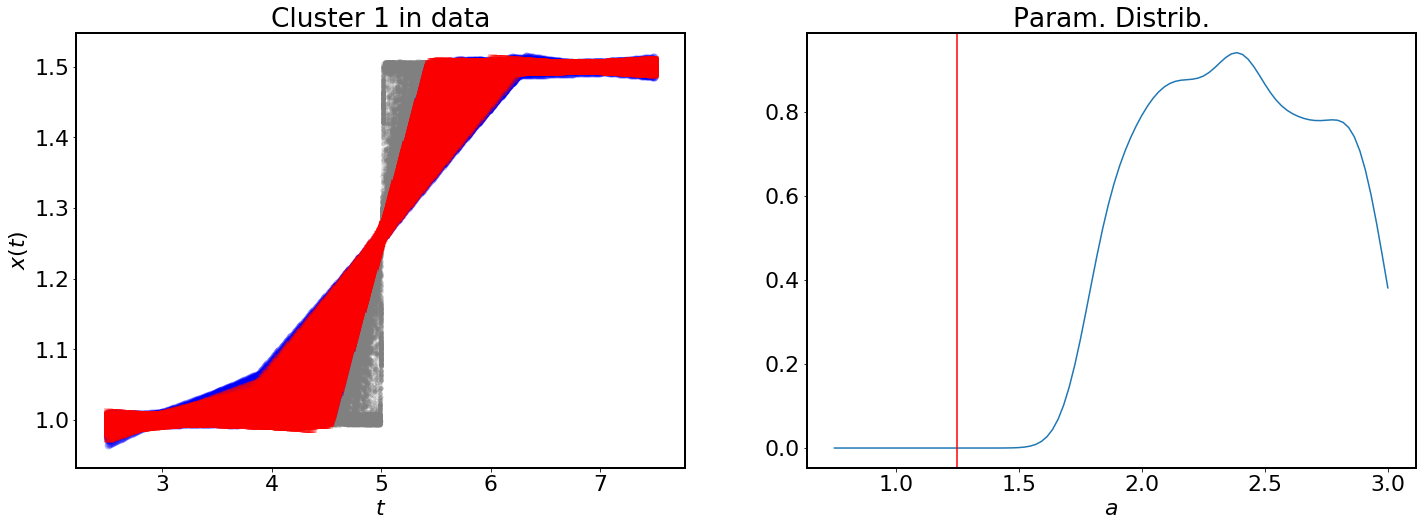

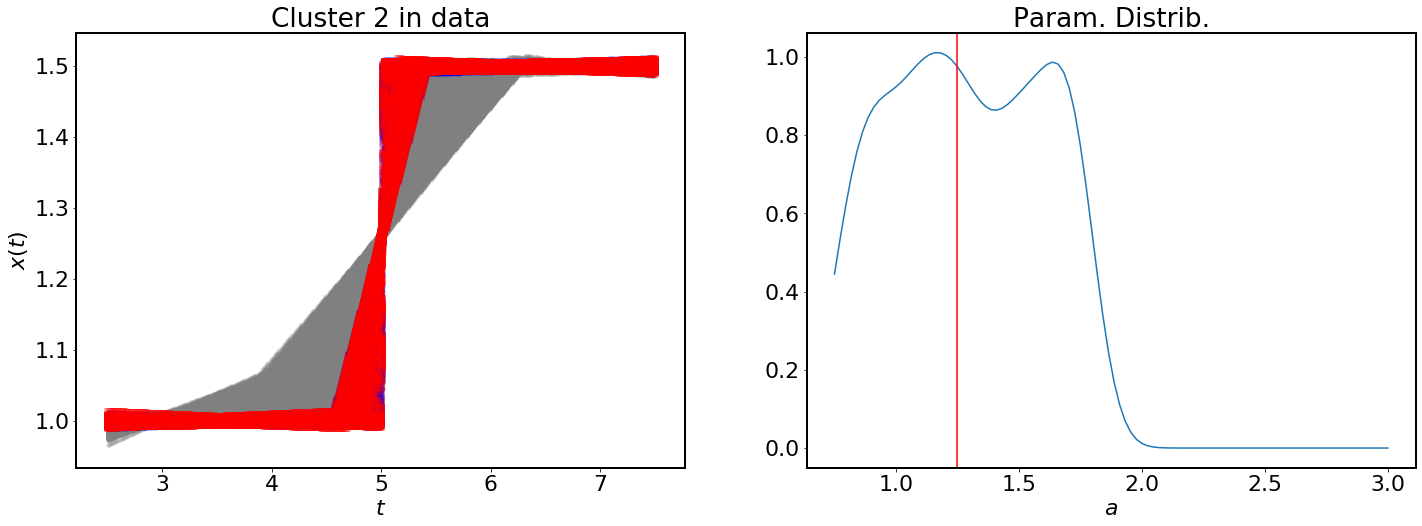

In [27]:
# # Plot clusters of predicted time series
# for j in range(learn.num_clusters):
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,2.5), gridspec_kw={'width_ratios': [3, 1]}) #(figsize=(10,5))
#     ps = []
#     for i in range(num_samples):
#         if learn2.predict_labels[i] == j:
#             ps.append(params[i,0])
#             ax1.plot(learn2.clean_times, learn2.clean_predictions[i, :])
#             #ax2.plot(times[time_start_idx : time_end_idx + 1], predicted_time_series[i, time_start_idx : time_end_idx + 1])
#     ax1.set(title='Cluster ' + str(j))
#     xs = np.linspace(param_range[0, 0], param_range[0,1], 100)
#     ax2.plot(xs, GKDE(ps)(xs))
#     ax2.set(xlabel=param_labels[0], title='Param. Distrib.')

# # Plot clusters of predicted time series
num_clean_obs2 = learn2.clean_times.shape[0]
for j in range(learn2.num_clusters):
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(24,8), gridspec_kw={'width_ratios': [1, 1]}) 
    ax1.scatter(np.tile(learn2.clean_times,num_samples).reshape(num_samples, num_clean_obs2), 
                learn2.clean_predictions, 50, c='gray', marker='.', alpha=0.2)
    idx = np.where(learn2.predict_labels == j)[0]
    ax1.scatter(np.tile(learn2.clean_times,len(idx)).reshape(len(idx),num_clean_obs2), 
                learn2.clean_predictions[idx,:], 50, c='b', marker='o', alpha=0.2)
    idx2 = np.where(learn2.obs_labels == j)[0]    
    ax1.scatter(np.tile(learn2.clean_times,len(idx2)).reshape(len(idx2),num_clean_obs), 
                learn2.clean_obs[idx2, :], 50, c='r', marker='s', alpha=0.2)
    ax1.set(title='Cluster ' + str(j+1) + ' in data')
    ax1.set_xlabel('$t$')
    ax1.set_ylabel('$x(t)$')
    
    xs = np.linspace(param_range[0, 0], param_range[0, 1], 100)
    ax2.plot(xs, GKDE(params[idx].flat[:])(xs))
    ax2.axvline(x=1.25, ymin=0.0, ymax=1.0, color='r')

    ax2.set(xlabel=param_labels[0], title='Param. Distrib.')
    
#     ax2.scatter(params[:,0], params[:,1], 30, c='gray', marker='.', alpha=0.2)
#     ax2.scatter(params[idx,0], params[idx,1], 50, c='blue', marker='o')
#     ax2.set(title='Cluster ' + str(j+1) + ' in parameters')
#     ax2.set_ylabel(param_labels[1])
#     ax2.set_xlabel(param_labels[0])
#     xs = np.linspace(param_range[0,0], param_range[0,1], 100)
#     ys1 = np.sqrt(0.5*(1.0 - np.sqrt(1.0 - 8.0*xs) -2.0*xs))
#     ys2 = np.sqrt(0.5*(1.0 + np.sqrt(1.0 - 8.0*xs) -2.0*xs))
#     ax2.plot(xs, ys1, 'r-', linewidth=3)
#     ax2.plot(xs, ys2, 'r-', linewidth=3)
    fig.tight_layout

In [28]:
# # Plot observed and predicted clusters
# for j in range(learn2.num_clusters):
#     plt.figure()
#     cluster_num = j
#     for i in range(num_samples):
#         if learn2.predict_labels[i] == cluster_num:
#             plt.plot(learn2.clean_times, learn2.clean_predictions[i,:],'b*')
#     for i in range(num_obs2):
#         if learn2.obs_labels[i] == cluster_num:
#             plt.plot(learn2.clean_times, learn2.clean_obs[i,:],'ro')

In [29]:
# Find best KPCA transformation for given number of QoI and transform time series data.
predict_map2, obs_map2 = learn2.learn_qois_and_transform(num_qoi=1) #variance_rate=0.95) #num_qoi=1)

1 principal components explain 50.9433% of variance for cluster 0 with {'kernel': 'linear'}
1 principal components explain 18.0423% of variance for cluster 0 with {'kernel': 'rbf'}
1 principal components explain 51.0037% of variance for cluster 0 with {'kernel': 'sigmoid'}
1 principal components explain 30.5894% of variance for cluster 0 with {'kernel': 'poly'}
1 principal components explain 42.4478% of variance for cluster 0 with {'kernel': 'cosine'}
Best kPCA for cluster  0  is  {'kernel': 'sigmoid'}
1 principal components explain 51.0037% of variance.
1 principal components explain 28.3611% of variance for cluster 1 with {'kernel': 'linear'}
1 principal components explain 11.0657% of variance for cluster 1 with {'kernel': 'rbf'}
1 principal components explain 25.3444% of variance for cluster 1 with {'kernel': 'sigmoid'}
1 principal components explain 12.6581% of variance for cluster 1 with {'kernel': 'poly'}
1 principal components explain 26.1946% of variance for cluster 1 with {'ke

In [30]:
%reset -f out

def plot_gap(all_eig_vals, n, cluster):
    fig = plt.figure(figsize=(10,10))
    fig.clear()
    #Plotting until maximum number of knots
    eig_vals = all_eig_vals[cluster].lambdas_[0:10]
    plt.semilogy(np.arange(np.size(eig_vals))+1,eig_vals/np.sum(eig_vals)*100, Marker='.', MarkerSize=20, linestyle='')
    plt.semilogy(np.arange(np.size(eig_vals))+1,eig_vals[n]/np.sum(eig_vals)*100*np.ones(np.size(eig_vals)), 'k--')
    plt.semilogy(np.arange(np.size(eig_vals))+1,eig_vals[n+1]/np.sum(eig_vals)*100*np.ones(np.size(eig_vals)), 'r--')
    plt.text(n+1, eig_vals[n]/np.sum(eig_vals)*150, 
             r'%2.3f' %(np.sum(eig_vals[0:n+1])/np.sum(eig_vals)*100) + '% of variation explained by first ' + '%1d' %(n+1) + ' PCs.', 
                                                               {'color': 'k', 'fontsize': 20})
    plt.text(n+2, eig_vals[n+1]/np.sum(eig_vals)*150, 
             r'Order of magnitude of gap is %4.2f.' %(np.log10(eig_vals[n])-np.log10(eig_vals[n+1])), 
                                                               {'color': 'r', 'fontsize': 20})
    s = 'Determining QoI for cluster #%1d' %(cluster+1)
    plt.title(s)
    plt.xlabel('Principal Component #')
    plt.ylabel('% of Variation')
    plt.xlim([0.1, np.size(eig_vals)+1])
    plt.ylim([0,500])


wd.interact(plot_gap, all_eig_vals=wd.fixed(learn2.kpcas),
            n = wd.IntSlider(value=0, min=0, max=5),
            cluster = wd.IntSlider(value=0, min=0, max=learn2.num_clusters-1))

Flushing output cache (2 entries)


interactive(children=(IntSlider(value=0, description='n', max=5), IntSlider(value=0, description='cluster', ma…

<function __main__.plot_gap(all_eig_vals, n, cluster)>

In [31]:
# Generate kernel density estimates on new QoI
learn2.generate_kdes()
# Calculate rejection rates for each cluster and print averages.
r_vals2=learn2.compute_r()

Diagnostic for clusters [sample average of ratios in each cluster]: [1.005980880691002, 0.9790605496503271]


In [32]:
# Compute marginal probablities for each parameter and initial condition.
param2_marginals = []
true_param_marginals = []
lam_ptr2 = []
cluster_weights2 = []
for i in range(learn2.num_clusters):
    lam_ptr2.append(np.where(learn2.predict_labels == i)[0])
    cluster_weights2.append(len(np.where(learn2.obs_labels == i)[0]) / num_obs)

for i in range(params.shape[1]):
    true_param_marginals.append(GKDE(params_obs2[:,i]))
    param2_marginals.append([])
    for j in range(learn2.num_clusters):
        param2_marginals[i].append(GKDE(params[lam_ptr2[j], i], weights=learn2.r[j]))

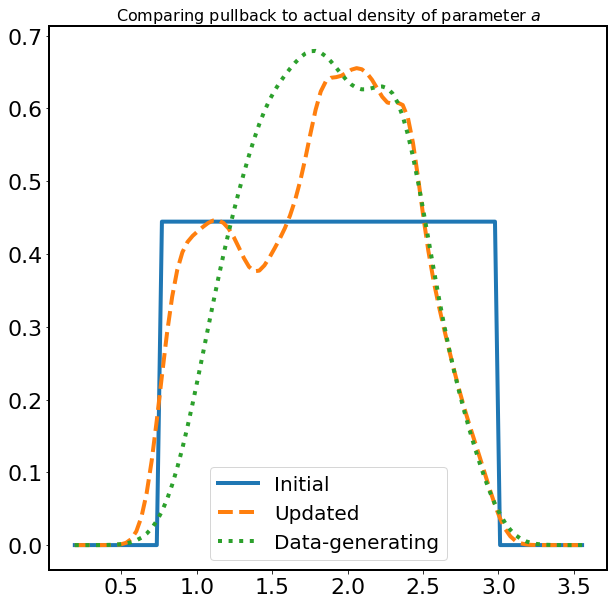

In [33]:
# Plot predicted marginal densities for parameters

for i in range(params.shape[1]):
    fig = plt.figure(figsize=(10,10))
    fig.clear()
    x_min = min(min(params[:, i]), min(params_obs[:, i]))
    x_max = max(max(params[:, i]), max(params_obs[:, i]))
    delt = 0.25*(x_max - x_min)
    x = np.linspace(x_min-delt, x_max+delt, 100)
    plt.plot(x, unif_dist(x, param_range[i, :]),
         label = 'Initial', linewidth=4)
    mar = np.zeros(x.shape)
    for j in range(learn2.num_clusters):
        mar += param2_marginals[i][j](x) * cluster_weights2[j]
    plt.plot(x, mar, label = 'Updated', linewidth=4, linestyle='dashed')
    plt.plot(x, true_param_marginals[i](x), label = 'Data-generating', 
             linewidth=4, linestyle='dotted')
    plt.title('Comparing pullback to actual density of parameter ' + param_labels[i], fontsize=16)
    plt.legend(fontsize=20)

In [34]:
# for i in range(params.shape[1]):
#     param_num=i
#     TV_metric = quad(param_init_error,param_range[i,0],param_range[i,1],maxiter=1000)
#     print(TV_metric)

In [35]:
def param2_update_KDE_error(x):
    mar = np.zeros(x.shape)
    for j in range(learn2.num_clusters):
        mar += param2_marginals[param_num][j](x) * cluster_weights2[j]
    return np.abs(mar-true_param_marginals[param_num](x))

for i in range(params.shape[1]):
    param_num=i
    TV_metric = quad(param2_update_KDE_error,param_range[i,0],param_range[i,1],maxiter=1000)
    print(TV_metric)

(0.19243088496140015, 8.590651051632037e-09)


In [36]:
# for i in range(params.shape[1]):
#     param_num=i
#     TV_metric = quad(KDE_error,param_range[i,0],param_range[i,1],maxiter=1000)
#     print(TV_metric)